In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
import glob
import shutil
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import random
import cv2
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve,auc
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import cv2 # Not directly used for image loading anymore but kept if you use it elsewhere
from sklearn.model_selection import train_test_split # Not needed for dataset split anymore
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay # Import for plotting
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # Import callbacks

tf.random.set_seed(42)
np.random.seed(42)




In [14]:
# --- USER-ADJUSTABLE TRAINING PARAMETERS ---
EPOCHS = 50      # Reduced epochs for faster training (try even less initially)
BATCH_SIZE = 64    # Increased batch size (adjust based on GPU memory)
IMAGE_SIZE = (128, 128) # Reduced image size for faster processing
FREQ_RESIZE_SHAPE = (IMAGE_SIZE[0] // 32, IMAGE_SIZE[1] // 32) # Adjust freq_resize_shape based on IMAGE_SIZE, assuming MobileNetV2 output downsampling of 32
SAMPLE_SIZE_PERCENT = None  # Set to None to use full dataset, or a float (e.g., 0.01) for sample - OPTION ADDED HERE

In [15]:
# Define base directory and target split ratios
base_dir = 'd:/deepfake/Celeb-DF-New'
output_dir = 'd:/deepfake/split_data'
split_ratios = {'train': 0.6, 'valid': 0.2, 'test': 0.2}

# Create output directories
for split in split_ratios.keys():
    for label in ['Real', 'Fake']:
        Path(f"{output_dir}/{split}/{label}").mkdir(parents=True, exist_ok=True)

In [16]:
# Function to split and copy images
def split_images(label, label_dir):
    # Get all images in the label directory
    images = os.listdir(label_dir)
    random.shuffle(images)  # Shuffle images

    # Calculate split sizes
    total_images = len(images)
    train_size = int(split_ratios['train'] * total_images)
    valid_size = int(split_ratios['valid'] * total_images)

    # Split images
    train_images = images[:train_size]
    valid_images = images[train_size:train_size + valid_size]
    test_images = images[train_size + valid_size:]

    # Function to copy files to output directory
    def copy_images(image_list, split):
        for img_file in image_list:
            src = os.path.join(label_dir, img_file)
            dest = os.path.join(output_dir, split, label, img_file)
            shutil.copy(src, dest)

    # Copy images to respective directories
    copy_images(train_images, 'train')
    copy_images(valid_images, 'valid')
    copy_images(test_images, 'test')

# Split and copy images for both labels
for label in ['Real', 'Fake']:
    label_dir = os.path.join(base_dir, label)
    split_images(label, label_dir)

print("Images have been split and saved to:", output_dir)


Images have been split and saved to: d:/deepfake/split_data


In [17]:
# Define base directories and split ratios
main_path = 'd:/deepfake//real_vs_fake/real-vs-fake'
second_main_path = 'd:/deepfake/Dataset'
third_main_path = 'd:/deepfake/split_data'  # Celeb-DF-New after splitting

# Standardized subdirectory names for datasets
sub_dirs_mapping = {
    'train': ['train', 'Train', 'train'],  # Train for Deepfake, train for others
    'valid': ['valid', 'Validation', 'valid'],  # Validation for Deepfake, valid for others
    'test': ['test', 'Test', 'test']  # Test for Deepfake, test for others
}

# Label mapping for real and fake folders
label_mapping = {'Real': 1, 'Fake': 0, 'real': 1, 'fake': 0}



In [18]:
# Function to create a DataFrame for a given base path and subdirectory
def create_dataframe(base_path, sub_dir, label_map, sample_percent=None): # sample_percent defaults to None
    data = {"file_path": [], "label": []}
    for label_dir, label in label_map.items():  # Iterate over 'Real' and 'Fake'
        folder_path = os.path.join(base_path, sub_dir, label_dir)
        if os.path.exists(folder_path):  # Ensure the folder exists
            img_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))] # Get image files
            if sample_percent is not None and 0 < sample_percent < 1.0: # Sample only if sample_percent is a float between 0 and 1
                sample_size = int(len(img_files) * sample_percent)
                img_files = random.sample(img_files, sample_size) # Randomly sample
            for img_file in img_files:
                data["file_path"].append(os.path.join(folder_path, img_file))
                data["label"].append(label)
    return pd.DataFrame(data)

# Function to create dataframes for each dataset separately and combined
def create_dataframes(sample_percent): # Pass sample_percent here
    dataframes = {}
    # Combined Dataframes (as before)
    for split_key, sub_dirs in sub_dirs_mapping.items():
        combined_data = pd.DataFrame()
        df_140k = create_dataframe(main_path, sub_dirs[0], label_mapping, sample_percent) # Pass sample_percent
        combined_data = pd.concat([combined_data, df_140k], ignore_index=True)
        df_deepfake = create_dataframe(second_main_path, sub_dirs[1], label_mapping, sample_percent) # Pass sample_percent
        combined_data = pd.concat([combined_data, df_deepfake], ignore_index=True)
        df_celeb = create_dataframe(third_main_path, sub_dirs[2], label_mapping, sample_percent) # Pass sample_percent
        combined_data = pd.concat([combined_data, df_celeb], ignore_index=True)
        dataframes[f'combined_{split_key}'] = combined_data

    # Separate Dataframes
    for split_key, sub_dirs in sub_dirs_mapping.items():
        dataframes[f'140k_{split_key}'] = create_dataframe(main_path, sub_dirs[0], label_mapping, sample_percent) # Pass sample_percent
        dataframes[f'deepfake_{split_key}'] = create_dataframe(second_main_path, sub_dirs[1], label_mapping, sample_percent) # Pass sample_percent
        dataframes[f'celebdf_{split_key}'] = create_dataframe(third_main_path, sub_dirs[2], label_mapping, sample_percent) # Pass sample_percent
    return dataframes

dataframes = create_dataframes(SAMPLE_SIZE_PERCENT) # Pass SAMPLE_SIZE_PERCENT when creating dataframes



In [19]:
# --- MODEL DEFINITION (LFAT - No changes needed here unless you want to adjust architecture) ---
def transformer_encoder(inputs, num_heads, key_dim, ffn_dim, num_layers):
    x = inputs
    for _ in range(num_layers):
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
        x = layers.Add()([x, attn_output])
        x = layers.LayerNormalization()(x)
        ffn_output = layers.Dense(ffn_dim, activation='relu')(x)
        ffn_output = layers.Dense(inputs.shape[-1])(ffn_output)
        x = layers.Add()([x, ffn_output])
        x = layers.LayerNormalization()(x)
    return x


class FrequencyAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(FrequencyAttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        cnn_feature_shape, freq_map_shape = input_shape
        self.channel_attention = layers.Dense(cnn_feature_shape[-1], activation='sigmoid') # Learn channel weights

    def call(self, inputs):
        cnn_features, freq_map = inputs

        # Global Average Pooling on Frequency Map
        frequency_attention_vector = tf.keras.layers.GlobalAveragePooling2D()(freq_map) # Shape (B, 1, 1) or (B, 1)

        # Learnable Transformation (FC layer to get channel weights)
        attention_weights = self.channel_attention(frequency_attention_vector) # Output shape (B, C), C = num_channels of cnn_features

        # Channel-wise Multiplication - Reshape weights to be broadcastable
        attention_weights = tf.reshape(attention_weights, (-1, 1, 1, cnn_features.shape[-1])) # Shape (B, 1, 1, C)

        # Apply attention to CNN features
        attended_cnn_features = cnn_features * attention_weights # Broadcasting will handle channel-wise multiplication
        return attended_cnn_features

class FrequencyTransformLayer(tf.keras.layers.Layer):
    def __init__(self, resize_shape=(224, 224), **kwargs):
        super(FrequencyTransformLayer, self).__init__(**kwargs)
        self.resize_shape = resize_shape  # Resize the frequency map to this shape

    def call(self, inputs):
        # Convert RGB to grayscale
        gray_image = tf.image.rgb_to_grayscale(inputs)

        # Compute 2D Fourier Transform (FFT) using TensorFlow
        fft = tf.signal.fft2d(tf.cast(gray_image, tf.complex64))

        # Calculate the Magnitude Spectrum
        magnitude_spectrum = tf.math.log1p(tf.abs(fft))

        # Resize the magnitude spectrum to match the CNN feature map size
        magnitude_spectrum_resized = tf.image.resize(
            magnitude_spectrum,
            self.resize_shape,
            method='bilinear'  # Bilinear interpolation
        )

        return magnitude_spectrum_resized


def build_lfat(input_shape=(224, 224, 3), freq_resize_shape=(7, 7)):  # Resize the frequency map to 7x7
    # Input layer
    image_input = layers.Input(shape=input_shape)

    # CNN Backbone (MobileNetV2)
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the backbone initially
    cnn_features = base_model(image_input)  # Shape (B, 7, 7, 1280)

    # Frequency Transformation
    freq_transform_layer = FrequencyTransformLayer(resize_shape=freq_resize_shape)(image_input)  # Use resized frequency map

    # Frequency-Aware Attention
    freq_attention = FrequencyAttentionLayer()([cnn_features, freq_transform_layer])

    # Transformer Encoder
    reshaped_features = layers.Reshape((-1, freq_attention.shape[-1]))(freq_attention)
    transformer_output = transformer_encoder(reshaped_features, num_heads=4, key_dim=64, ffn_dim=128, num_layers=2)

    # Classification Head
    pooled_features = layers.GlobalAveragePooling1D()(transformer_output)
    output = layers.Dense(1, activation='sigmoid')(pooled_features)

    return models.Model(inputs=image_input, outputs=output)




In [20]:
#IMAGE_SIZE = (224, 224) # Define image size, matching your model input - NOW USER ADJUSTABLE
#BATCH_SIZE = 32 # Define batch size - NOW USER ADJUSTABLE
#EPOCHS = 200 # Maximum epochs to train - NOW USER ADJUSTABLE
METRICS_INTERVAL = 25 # Interval to calculate and print metrics

def create_generators(train_df, valid_df, test_df):
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2
    )
    val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

    train_flow = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='file_path',
        y_col='label',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    val_flow = val_datagen.flow_from_dataframe(
        dataframe=valid_df,
        x_col='file_path',
        y_col='label',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )

    test_flow = val_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='file_path',
        y_col='label',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )
    return train_flow, val_flow, test_flow



In [21]:
def evaluate_model(model, test_flow, epoch=None):
    test_loss, test_accuracy = model.evaluate(test_flow, verbose=0)
    y_pred_prob = model.predict(test_flow, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int)
    y_test = test_flow.classes

    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_prob)

    if epoch is not None:
        print(f"Epoch {epoch} Test Metrics:")
    else:
        print("Final Test Metrics:")
    print(f"Loss: {test_loss:.4f}, Accuracy: {test_accuracy * 100:.2f}%")
    print(f"F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc_score:.4f}")

    return {
        'loss': test_loss,
        'accuracy': test_accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'auc': auc_score
    }



In [22]:
def train_and_evaluate(train_flow, val_flow, test_flow, dataset_name):
    lfat_model = build_lfat(input_shape=IMAGE_SIZE + (3,), freq_resize_shape=FREQ_RESIZE_SHAPE) # Pass user-defined IMAGE_SIZE and FREQ_RESIZE_SHAPE
    lfat_model.compile(optimizer=optimizers.AdamW(learning_rate=0.0001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

    checkpoint_path = f"d:/deepfake/LFAT_best_model_{dataset_name}234.h5"
    model_checkpoint = ModelCheckpoint(
        checkpoint_path,
        monitor="val_accuracy",
        save_best_only=True,
        mode="max",
        verbose=0,
        save_format='h5'  # Reduced verbosity during training epochs
    )

    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=10, # Increased patience for longer training
        restore_best_weights=True,
        verbose=0 # Reduced verbosity during training epochs
    )

    history = lfat_model.fit(
        train_flow,
        validation_data=val_flow,
        epochs=EPOCHS,
        verbose=1,
        callbacks=[model_checkpoint, early_stopping]
    )

    lfat_model.load_weights(checkpoint_path) # Load best weights

    print(f"\n--- {dataset_name.upper()} Dataset Training Finished ---")

    metrics_history = []
    for epoch in range(1, EPOCHS + 1):
        if epoch % METRICS_INTERVAL == 0 or epoch == EPOCHS:
            print(f"\n--- Epoch {epoch} Evaluation ---")
            epoch_metrics = evaluate_model(lfat_model, test_flow, epoch)
            epoch_metrics['epoch'] = epoch
            metrics_history.append(epoch_metrics)
        if epoch > early_stopping.patience and epoch - np.argmin(history.history['val_loss']) > early_stopping.patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break


    final_metrics_test = evaluate_model(lfat_model, test_flow) # Keep test metrics
    metrics_history.append({'epoch': 'Final Test', **final_metrics_test}) # Label as 'Final Test'

    # --- EVALUATION ON VALIDATION SET ---
    print(f"\n--- Validation Set Evaluation ---")
    final_metrics_val = evaluate_model(lfat_model, val_flow) # Evaluate on validation set
    metrics_history.append({'epoch': 'Final Validation', **final_metrics_val}) # Label as 'Final Validation'

    # --- Predictions for Confusion Matrix (Validation & Test) ---
    y_pred_prob_val = lfat_model.predict(val_flow, verbose=0)
    y_pred_binary_val = (y_pred_prob_val > 0.5).astype(int)
    y_val = val_flow.classes

    y_pred_prob_test = lfat_model.predict(test_flow, verbose=0) # Already have this, but recalculating for clarity
    y_pred_binary_test = (y_pred_prob_test > 0.5).astype(int)
    y_test = test_flow.classes

    # --- Calculate Confusion Matrices (Validation & Test) ---
    cm_val = confusion_matrix(y_val, y_pred_binary_val)
    cm_test = confusion_matrix(y_test, y_pred_binary_test)

    # --- ROC Curve Data (Validation & Test) ---
    fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_pred_prob_val)
    roc_auc_val = auc(fpr_val, tpr_val)

    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_prob_test) # Already have this, recalculating for clarity
    roc_auc_test = auc(fpr_test, tpr_test)


    # Plotting - Now 2 rows, 4 columns for validation and test plots
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(20, 10)) # Increased figure height for 2 rows

    # --- Row 1: Validation Set Plots ---
    plt.subplot(2, 4, 1) # Row 1, Col 1: Accuracy (using training history, but labeled Val)
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange', marker='x') # Just validation accuracy here for clarity
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{dataset_name.upper()} Validation Accuracy') # Validation title

    plt.subplot(2, 4, 2) # Row 1, Col 2: Loss (using training history, but labeled Val)
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange', marker='x') # Just validation loss
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{dataset_name.upper()} Validation Loss') # Validation title

    plt.subplot(2, 4, 3) # Row 1, Col 3: ROC Curve (Validation)
    plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc_val:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve - {dataset_name.upper()} (Validation)') # Validation title
    plt.legend(loc="lower right")

    plt.subplot(2, 4, 4) # Row 1, Col 4: Confusion Matrix (Validation)
    disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=['Fake', 'Real'])
    disp_val.plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.title(f'CM - {dataset_name.upper()} (Validation)') # Validation title


    # --- Row 2: Test Set Plots ---
    plt.subplot(2, 4, 5) # Row 2, Col 1: Accuracy (using training history, but labeled Test - actually training accuracy)
    plt.plot(epochs_range, acc, label='Train Accuracy', color='blue', marker='o') # Keeping train accuracy plot for reference
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{dataset_name.upper()} Train Accuracy (for reference)') # Clarified title

    plt.subplot(2, 4, 6) # Row 2, Col 2: Loss (using training history, but labeled Test - actually training loss)
    plt.plot(epochs_range, loss, label='Train Loss', color='blue', marker='o') # Keeping train loss for reference
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{dataset_name.upper()} Train Loss (for reference)') # Clarified title

    plt.subplot(2, 4, 7) # Row 2, Col 3: ROC Curve (Test)
    plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc_test:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve - {dataset_name.upper()} (Test)') # Test title
    plt.legend(loc="lower right")

    plt.subplot(2, 4, 8) # Row 2, Col 4: Confusion Matrix (Test)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Fake', 'Real'])
    disp_test.plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.title(f'CM - {dataset_name.upper()} (Test)') # Test title


    plt.tight_layout()
    plt.show()

    return metrics_history, history




Training and Evaluating on COMBINED Dataset
Found 542536 validated image filenames belonging to 2 classes.
Found 179268 validated image filenames belonging to 2 classes.
Found 122218 validated image filenames belonging to 2 classes.
Epoch 1/50
8478/8478 [==============================] - ETA: 0s - loss: 0.4669 - accuracy: 0.7683

C:\Users\rdars\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8478/8478 [==============================] - 7581s 894ms/step - loss: 0.4669 - accuracy: 0.7683 - val_loss: 0.3849 - val_accuracy: 0.8122
Epoch 2/50
8478/8478 [==============================] - 7420s 875ms/step - loss: 0.4089 - accuracy: 0.8060 - val_loss: 0.3624 - val_accuracy: 0.8241
Epoch 3/50
8478/8478 [==============================] - 7423s 876ms/step - loss: 0.3865 - accuracy: 0.8195 - val_loss: 0.3311 - val_accuracy: 0.8463
Epoch 4/50
8478/8478 [==============================] - 7394s 872ms/step - loss: 0.3723 - accuracy: 0.8281 - val_loss: 0.3466 - val_accuracy: 0.8358
Epoch 5/50
8478/8478 [==============================] - 7356s 868ms/step - loss: 0.3621 - accuracy: 0.8339 - val_loss: 0.3357 - val_accuracy: 0.8435
Epoch 6/50
8478/8478 [==============================] - 7382s 871ms/step - loss: 0.3524 - accuracy: 0.8387 - val_loss: 0.3430 - val_accuracy: 0.8407
Epoch 7/50
8478/8478 [==============================] - 7819s 922ms/step - loss: 0.3461 - accuracy: 0.8425 - val_loss

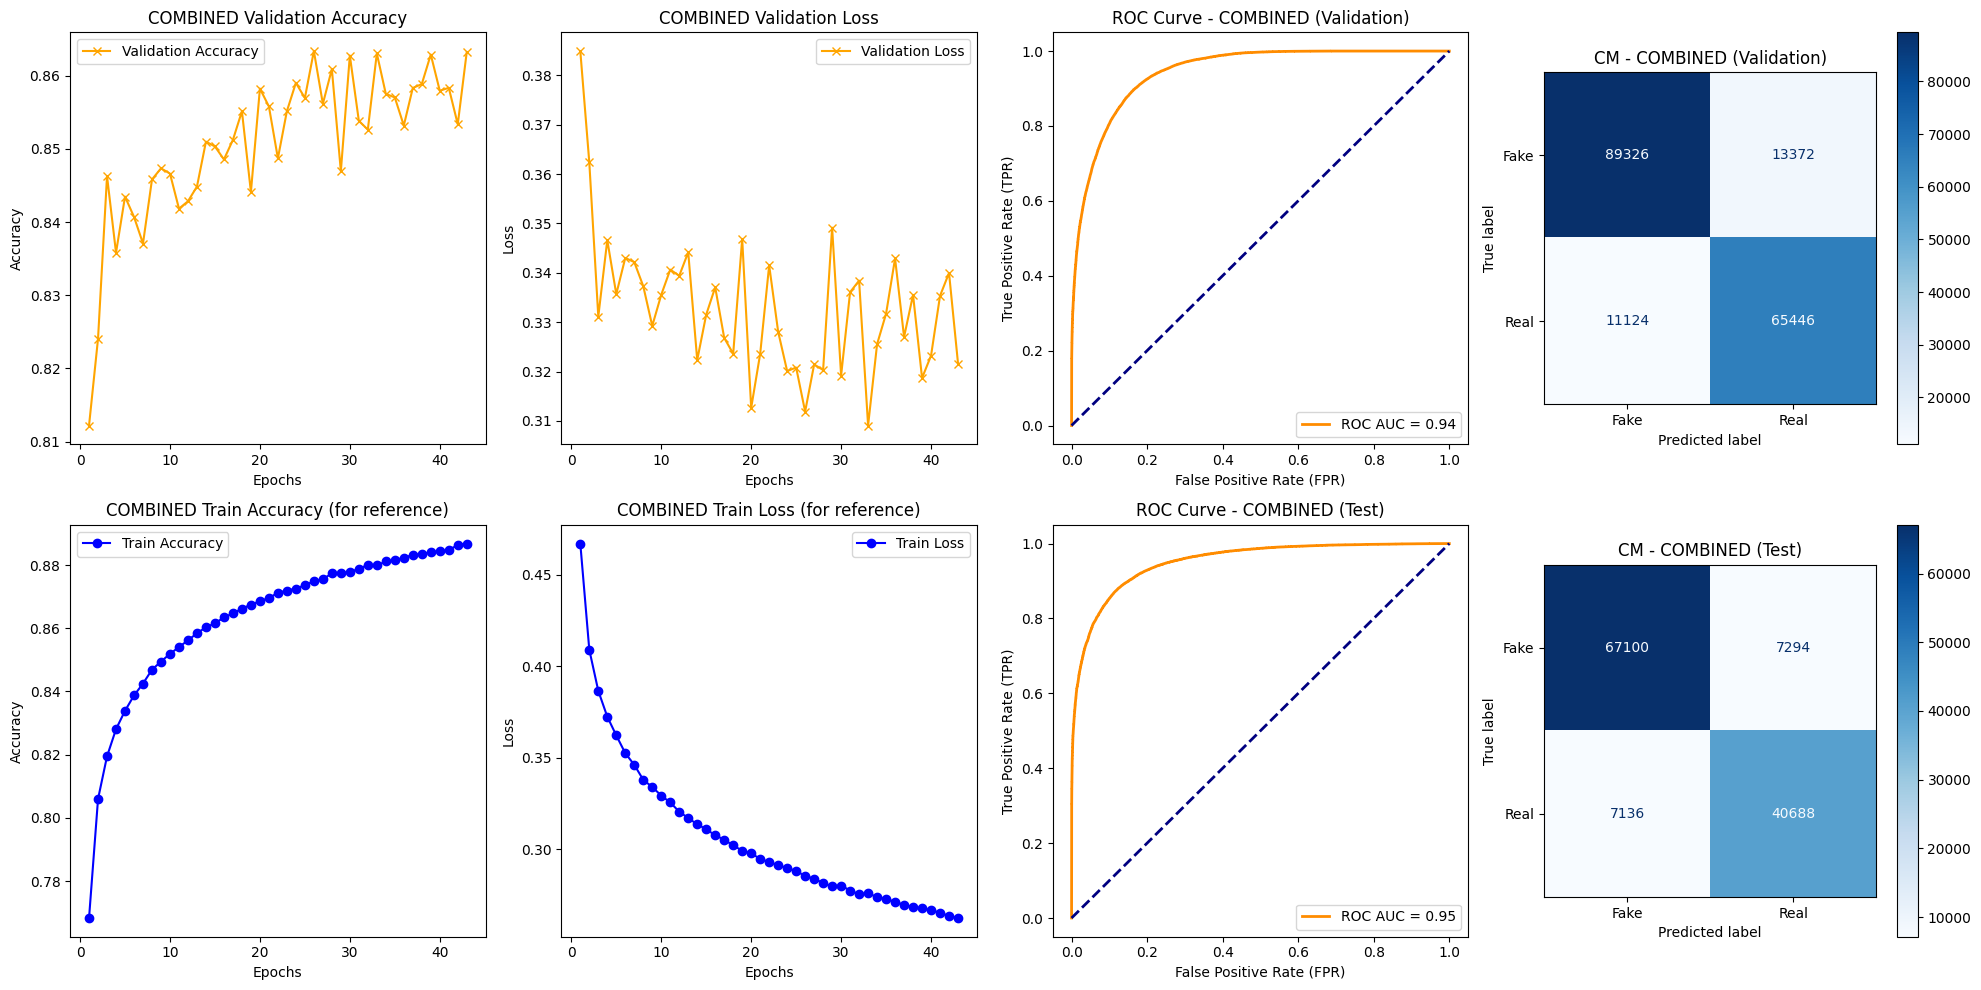


Training and Evaluating on 140K Dataset
Found 200000 validated image filenames belonging to 2 classes.
Found 40000 validated image filenames belonging to 2 classes.
Found 40000 validated image filenames belonging to 2 classes.
Epoch 1/50
3125/3125 [==============================] - ETA: 0s - loss: 0.5260 - accuracy: 0.7358

C:\Users\rdars\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3125/3125 [==============================] - 2145s 685ms/step - loss: 0.5260 - accuracy: 0.7358 - val_loss: 0.4972 - val_accuracy: 0.7606
Epoch 2/50
3125/3125 [==============================] - 2014s 645ms/step - loss: 0.4529 - accuracy: 0.7856 - val_loss: 0.4234 - val_accuracy: 0.8043
Epoch 3/50
3125/3125 [==============================] - 1498s 479ms/step - loss: 0.4177 - accuracy: 0.8079 - val_loss: 0.4061 - val_accuracy: 0.8141
Epoch 4/50
3125/3125 [==============================] - 2014s 644ms/step - loss: 0.3943 - accuracy: 0.8194 - val_loss: 0.3966 - val_accuracy: 0.8212
Epoch 5/50
3125/3125 [==============================] - 1495s 478ms/step - loss: 0.3797 - accuracy: 0.8279 - val_loss: 0.4143 - val_accuracy: 0.8144
Epoch 6/50
3125/3125 [==============================] - 1975s 632ms/step - loss: 0.3634 - accuracy: 0.8370 - val_loss: 0.4203 - val_accuracy: 0.8155
Epoch 7/50
3125/3125 [==============================] - 1496s 479ms/step - loss: 0.3537 - accuracy: 0.8431 - val_loss

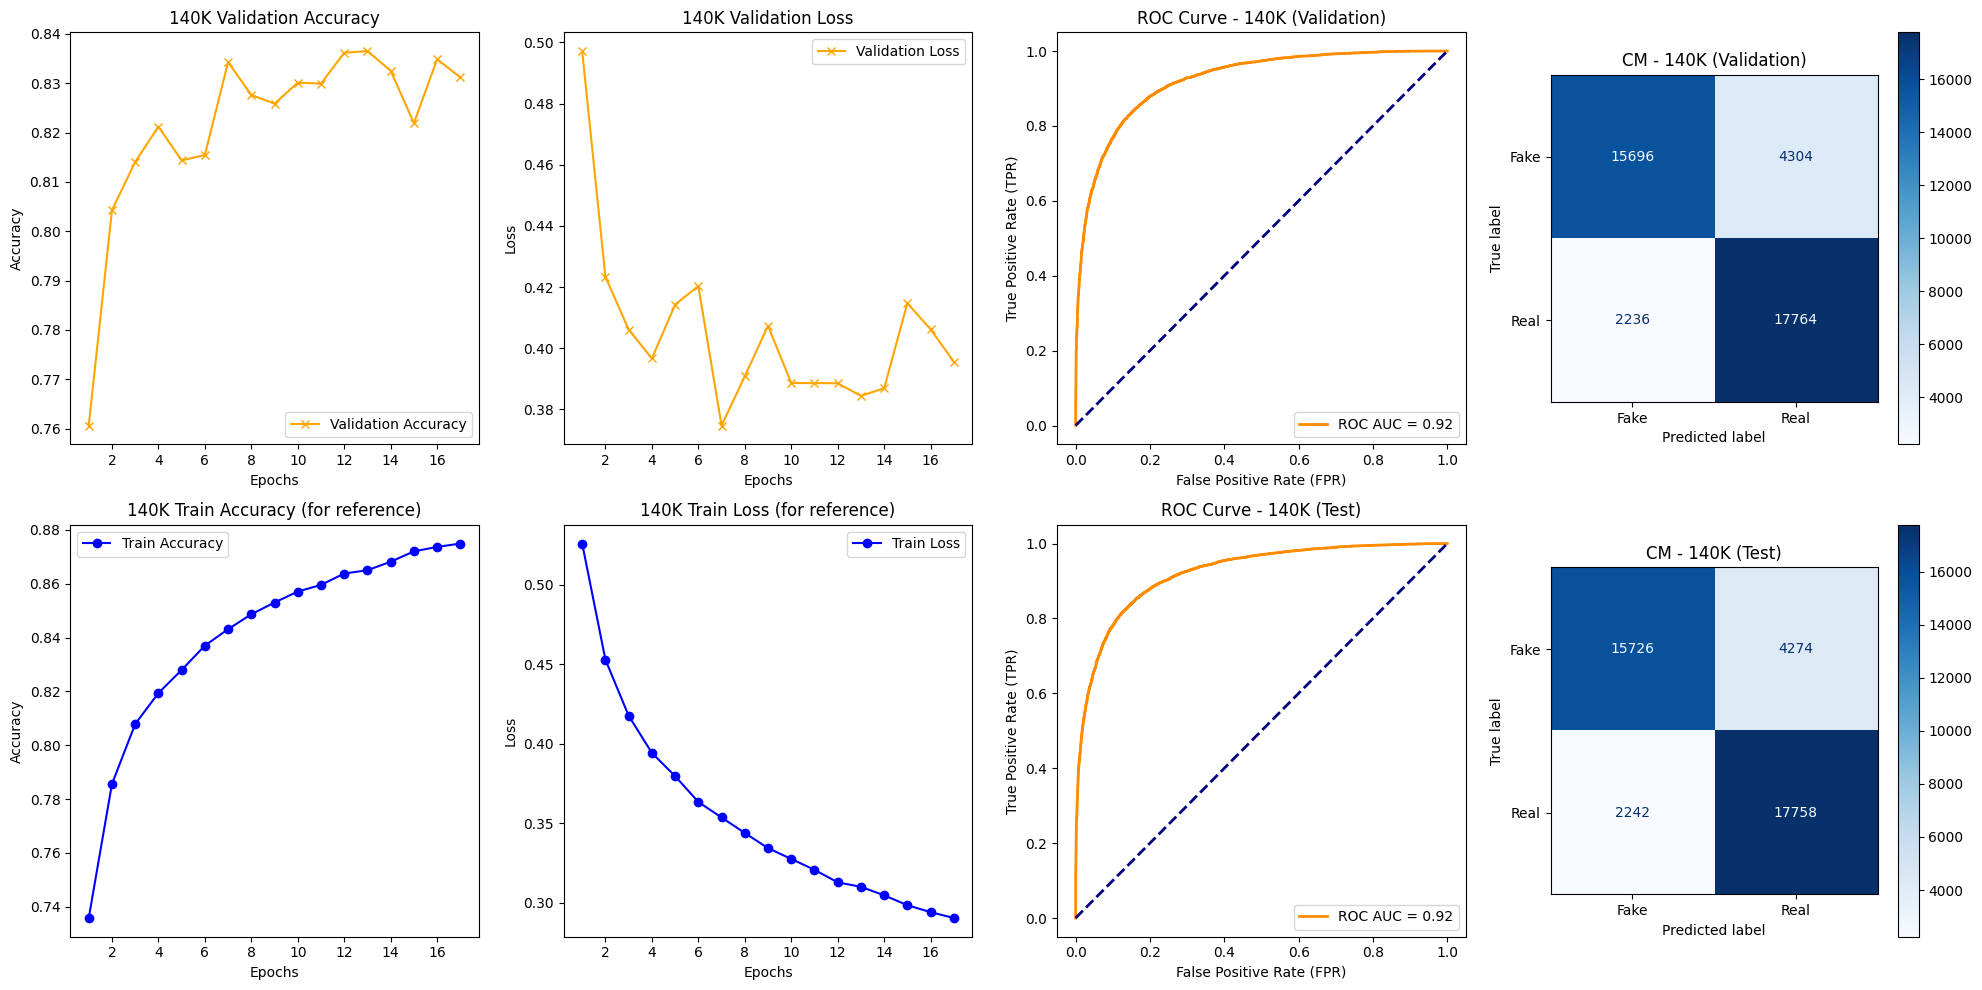


Training and Evaluating on DEEPFAKE Dataset
Found 280004 validated image filenames belonging to 2 classes.
Found 78856 validated image filenames belonging to 2 classes.
Found 21810 validated image filenames belonging to 2 classes.
Epoch 1/50
4376/4376 [==============================] - ETA: 0s - loss: 0.4329 - accuracy: 0.7927

C:\Users\rdars\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4376/4376 [==============================] - 3121s 712ms/step - loss: 0.4329 - accuracy: 0.7927 - val_loss: 0.4572 - val_accuracy: 0.7850
Epoch 2/50
4376/4376 [==============================] - 3086s 705ms/step - loss: 0.3897 - accuracy: 0.8178 - val_loss: 0.4303 - val_accuracy: 0.8017
Epoch 3/50
4376/4376 [==============================] - 2990s 683ms/step - loss: 0.3720 - accuracy: 0.8286 - val_loss: 0.4125 - val_accuracy: 0.8083
Epoch 4/50
4376/4376 [==============================] - 2861s 654ms/step - loss: 0.3594 - accuracy: 0.8353 - val_loss: 0.4433 - val_accuracy: 0.7927
Epoch 5/50
4376/4376 [==============================] - 2573s 588ms/step - loss: 0.3486 - accuracy: 0.8415 - val_loss: 0.4430 - val_accuracy: 0.7951
Epoch 6/50
4376/4376 [==============================] - 2745s 627ms/step - loss: 0.3415 - accuracy: 0.8451 - val_loss: 0.4515 - val_accuracy: 0.7906
Epoch 7/50
4376/4376 [==============================] - 3341s 764ms/step - loss: 0.3357 - accuracy: 0.8487 - val_loss

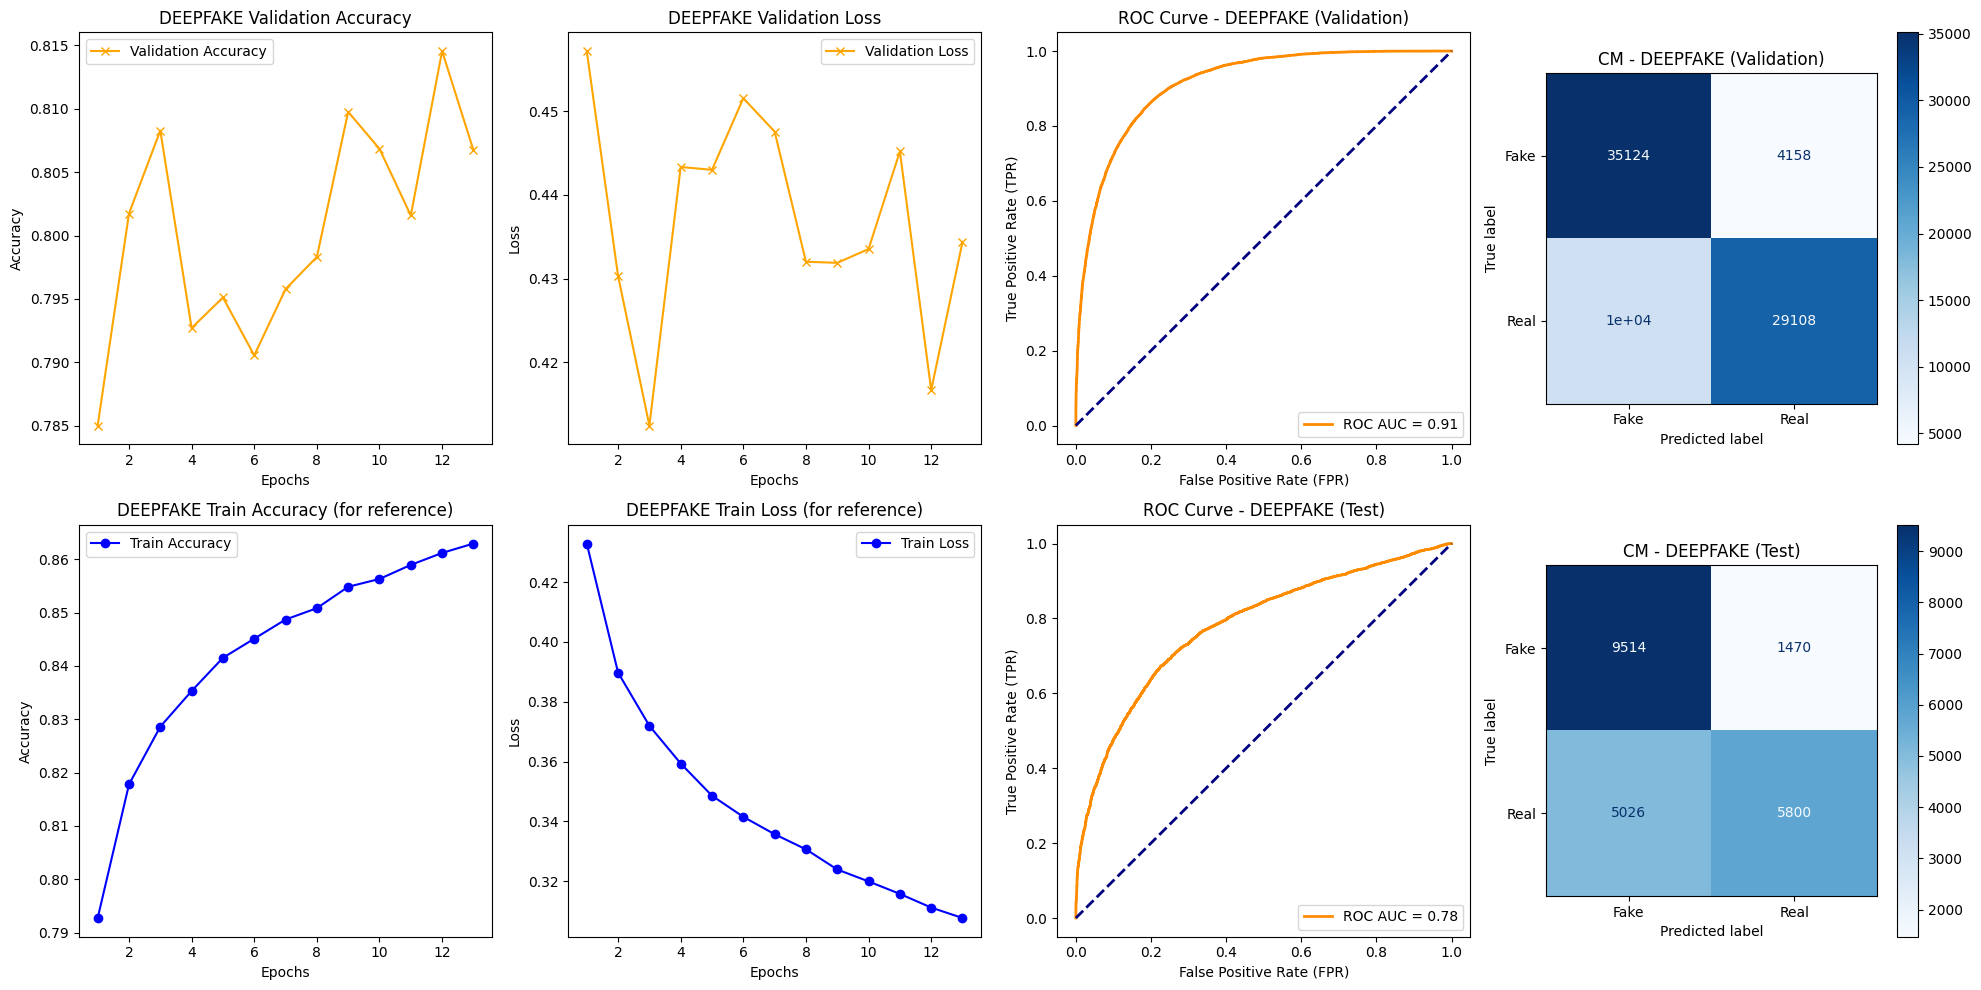


Training and Evaluating on CELEBDF Dataset
Found 62532 validated image filenames belonging to 2 classes.
Found 60412 validated image filenames belonging to 2 classes.
Found 60408 validated image filenames belonging to 2 classes.
Epoch 1/50
978/978 [==============================] - ETA: 0s - loss: 0.1349 - accuracy: 0.9462

C:\Users\rdars\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


978/978 [==============================] - 933s 950ms/step - loss: 0.1349 - accuracy: 0.9462 - val_loss: 0.0658 - val_accuracy: 0.9741
Epoch 2/50
978/978 [==============================] - 649s 664ms/step - loss: 0.0861 - accuracy: 0.9672 - val_loss: 0.0842 - val_accuracy: 0.9684
Epoch 3/50
978/978 [==============================] - 648s 662ms/step - loss: 0.0659 - accuracy: 0.9743 - val_loss: 0.0630 - val_accuracy: 0.9768
Epoch 4/50
978/978 [==============================] - 650s 665ms/step - loss: 0.0579 - accuracy: 0.9781 - val_loss: 0.0594 - val_accuracy: 0.9796
Epoch 5/50
978/978 [==============================] - 649s 664ms/step - loss: 0.0509 - accuracy: 0.9805 - val_loss: 0.0598 - val_accuracy: 0.9785
Epoch 6/50
978/978 [==============================] - 654s 669ms/step - loss: 0.0464 - accuracy: 0.9832 - val_loss: 0.0513 - val_accuracy: 0.9805
Epoch 7/50
978/978 [==============================] - 653s 668ms/step - loss: 0.0410 - accuracy: 0.9847 - val_loss: 0.0271 - val_accura

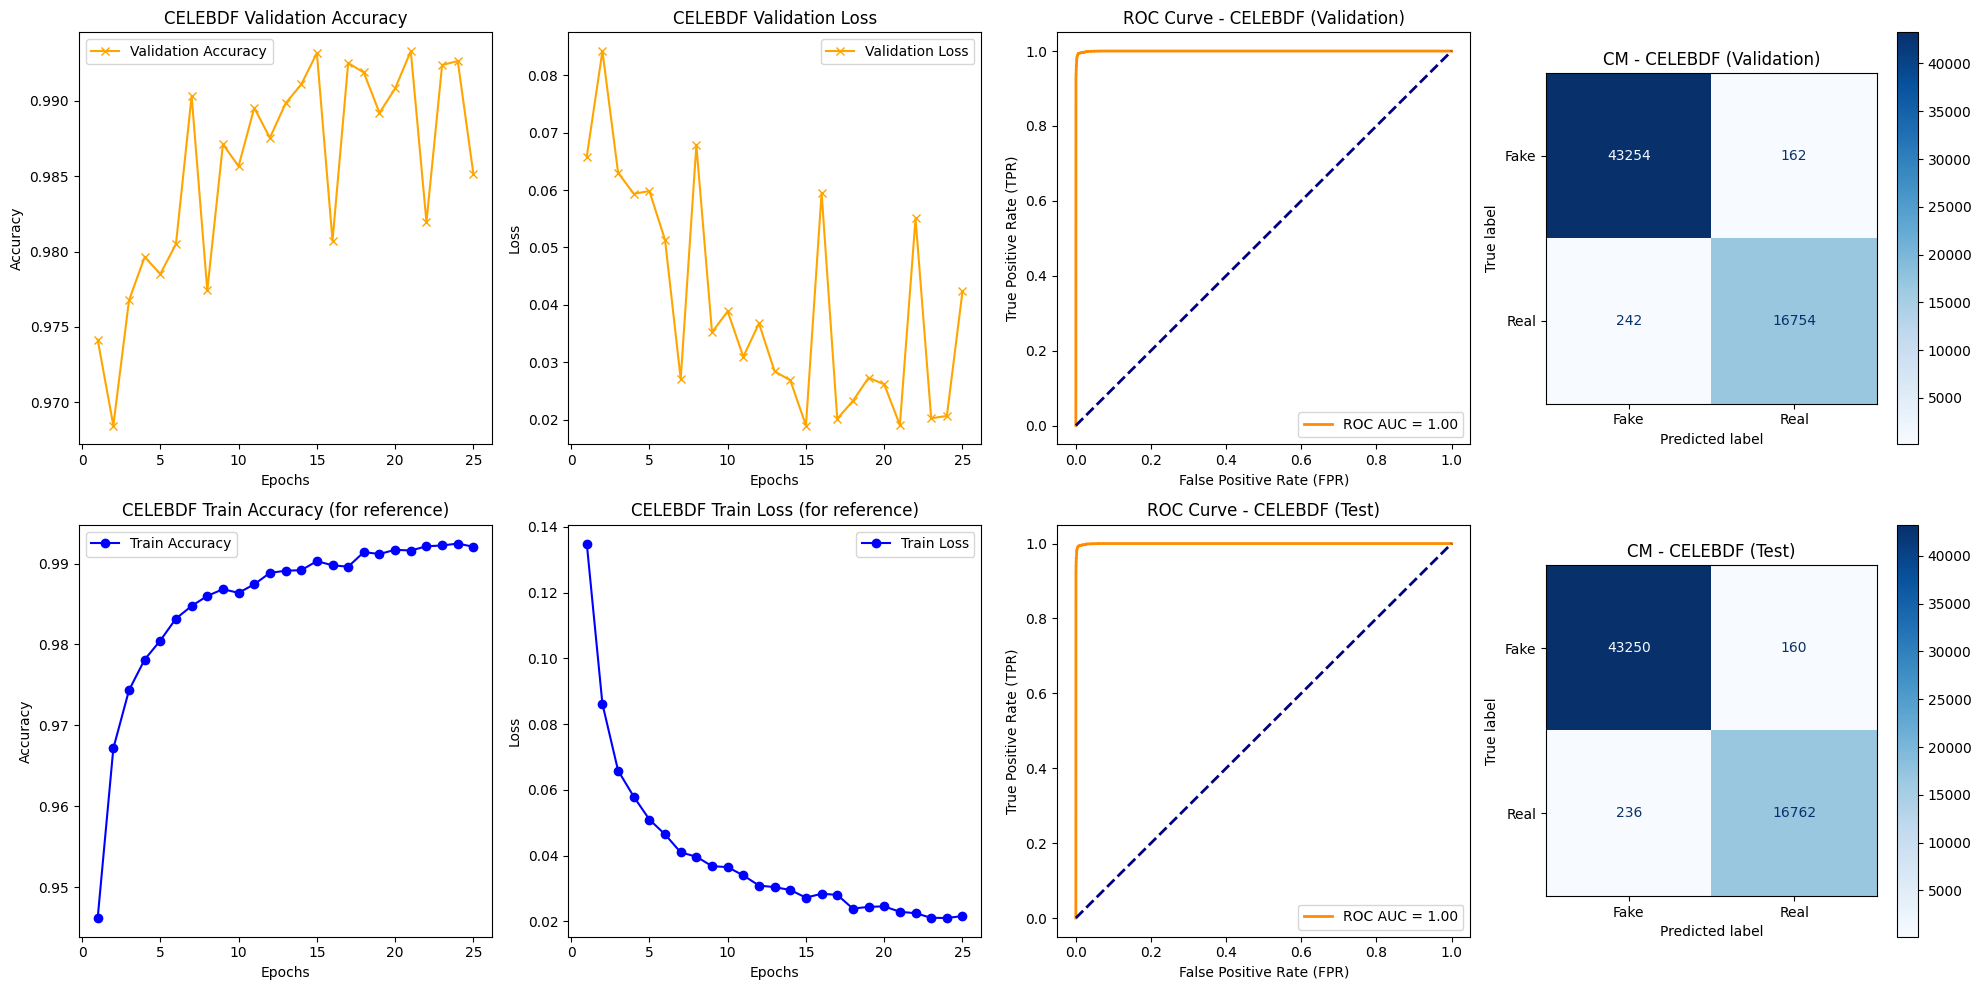


--- Training and Evaluation Complete for All Datasets ---

--- COMBINED Dataset Metrics ---
       loss  accuracy        f1  precision    recall       auc  \
0  0.303558  0.881932  0.849383   0.847985  0.850786  0.950886   
1  0.303558  0.881932  0.849383   0.847985  0.850786  0.950886   
2  0.311881  0.863355  0.842356   0.830343  0.854721  0.943325   

              epoch  
0                25  
1        Final Test  
2  Final Validation  

--- 140K Dataset Metrics ---
              epoch      loss  accuracy        f1  precision  recall       auc
0        Final Test  0.382300    0.8371  0.844975   0.806009  0.8879  0.922088
1  Final Validation  0.384428    0.8365  0.844537   0.804966  0.8882  0.921525

--- DEEPFAKE Dataset Metrics ---
              epoch      loss  accuracy        f1  precision    recall  \
0        Final Test  0.870354  0.702155  0.641026   0.797799  0.535747   
1  Final Validation  0.416685  0.814548  0.799231   0.875008  0.735533   

        auc  
0  0.780761  
1 

In [23]:
# Dataset names and corresponding dataframes
dataset_configs = {
    "140k": dataframes,
    "deepfake": dataframes,
    "celebdf": dataframes,
    "combined": dataframes
}

all_metrics = {}
all_histories = {}

dataset_order = ["combined", "140k", "deepfake", "celebdf"] # Define the desired dataset order
for dataset_name in dataset_order:
    print(f"\n{'='*50}")
    print(f"Training and Evaluating on {dataset_name.upper()} Dataset")
    print(f"{'='*50}")

    train_df = dataframes[f'{dataset_name}_train']
    valid_df = dataframes[f'{dataset_name}_valid']
    test_df = dataframes[f'{dataset_name}_test']

    # Ensure labels are string type
    train_df['label'] = train_df['label'].astype(str)
    valid_df['label'] = valid_df['label'].astype(str)
    test_df['label'] = test_df['label'].astype(str)
    if not train_df.empty and not valid_df.empty and not test_df.empty: # Check if dataframes are not empty before creating generators
        train_flow, val_flow, test_flow = create_generators(train_df, valid_df, test_df)
        metrics, history = train_and_evaluate(train_flow, val_flow, test_flow, dataset_name)

        all_metrics[dataset_name] = metrics
        all_histories[dataset_name] = history
    else:
        print(f"Warning: DataFrames for {dataset_name.upper()} dataset are empty. Skipping training and evaluation.")

    

print("\n--- Training and Evaluation Complete for All Datasets ---")

# Print metrics summary
for dataset_name, metrics_list in all_metrics.items():
    print(f"\n--- {dataset_name.upper()} Dataset Metrics ---")
    metrics_df = pd.DataFrame(metrics_list)
    print(metrics_df)

In [38]:
def create_dataframe(base_path, sub_dir, label_map, sample_percent=None): # sample_percent defaults to None
    data = {"file_path": [], "label": []}
    for label_dir, label in label_map.items():  # Iterate over 'Real' and 'Fake'
        # --- START OF MARKED CHANGE ---
        folder_path = os.path.join(base_path, sub_dir, label_dir)
        print(f"Checking folder path: {folder_path}") # DEBUG PRINT - Check the path being constructed
        # --- END OF MARKED CHANGE ---
        if os.path.exists(folder_path):  # Ensure the folder exists
            img_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))] # Get image files
            if sample_percent is not None and 0 < sample_percent < 1.0: # Sample only if sample_percent is a float between 0 and 1
                sample_size = int(len(img_files) * sample_percent)
                img_files = random.sample(img_files, sample_size) # Randomly sample
            for img_file in img_files:
                data["file_path"].append(os.path.join(folder_path, img_file))
                data["label"].append(label)
        else:
            print(f"Warning: Folder path does not exist: {folder_path}") # DEBUG PRINT - Folder not found
    return pd.DataFrame(data)



Training and Evaluating on DEEPFAKE Dataset

--- DEEPFAKE Dataset DataFrame Shapes and Heads (Before Generators) ---
Train DataFrame shape: (5600, 2)
Validation DataFrame shape: (1574, 2)
Test DataFrame shape: (434, 2)

Train DataFrame head:
                                       file_path  label
0  d:/deepfake/Dataset\Train\Real\real_36625.jpg      1
1  d:/deepfake/Dataset\Train\Real\real_52276.jpg      1
2  d:/deepfake/Dataset\Train\Real\real_59139.jpg      1
3  d:/deepfake/Dataset\Train\Real\real_53844.jpg      1
4  d:/deepfake/Dataset\Train\Real\real_10602.jpg      1

Validation DataFrame head:
                                           file_path  label
0  d:/deepfake/Dataset\Validation\Real\real_4353.jpg      1
1  d:/deepfake/Dataset\Validation\Real\real_7037.jpg      1
2  d:/deepfake/Dataset\Validation\Real\real_18519...      1
3  d:/deepfake/Dataset\Validation\Real\real_3933.jpg      1
4   d:/deepfake/Dataset\Validation\Real\real_261.jpg      1

Test DataFrame head:
           

C:\Users\rdars\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 93s 1s/step - loss: 0.5553 - accuracy: 0.7121 - val_loss: 0.5579 - val_accuracy: 0.7166
Epoch 2/50
88/88 [==============================] - 42s 481ms/step - loss: 0.4870 - accuracy: 0.7645 - val_loss: 0.4924 - val_accuracy: 0.7471
Epoch 3/50
88/88 [==============================] - 43s 488ms/step - loss: 0.4726 - accuracy: 0.7732 - val_loss: 0.5238 - val_accuracy: 0.7344
Epoch 4/50
88/88 [==============================] - 45s 510ms/step - loss: 0.4466 - accuracy: 0.7825 - val_loss: 0.4722 - val_accuracy: 0.7853
Epoch 5/50
88/88 [==============================] - 43s 492ms/step - loss: 0.4444 - accuracy: 0.7834 - val_loss: 0.4700 - val_accuracy: 0.7726
Epoch 6/50
88/88 [==============================] - 46s 527ms/step - loss: 0.4373 - accuracy: 0.7914 - val_loss: 0.5705 - val_accuracy: 0.7109
Epoch 7/50
88/88 [==============================] - 45s 507ms/step - loss: 0.4258 - accuracy: 0.8025 - val_loss: 0.5235 - val_accuracy: 0.7382
Epoch 8/50
88

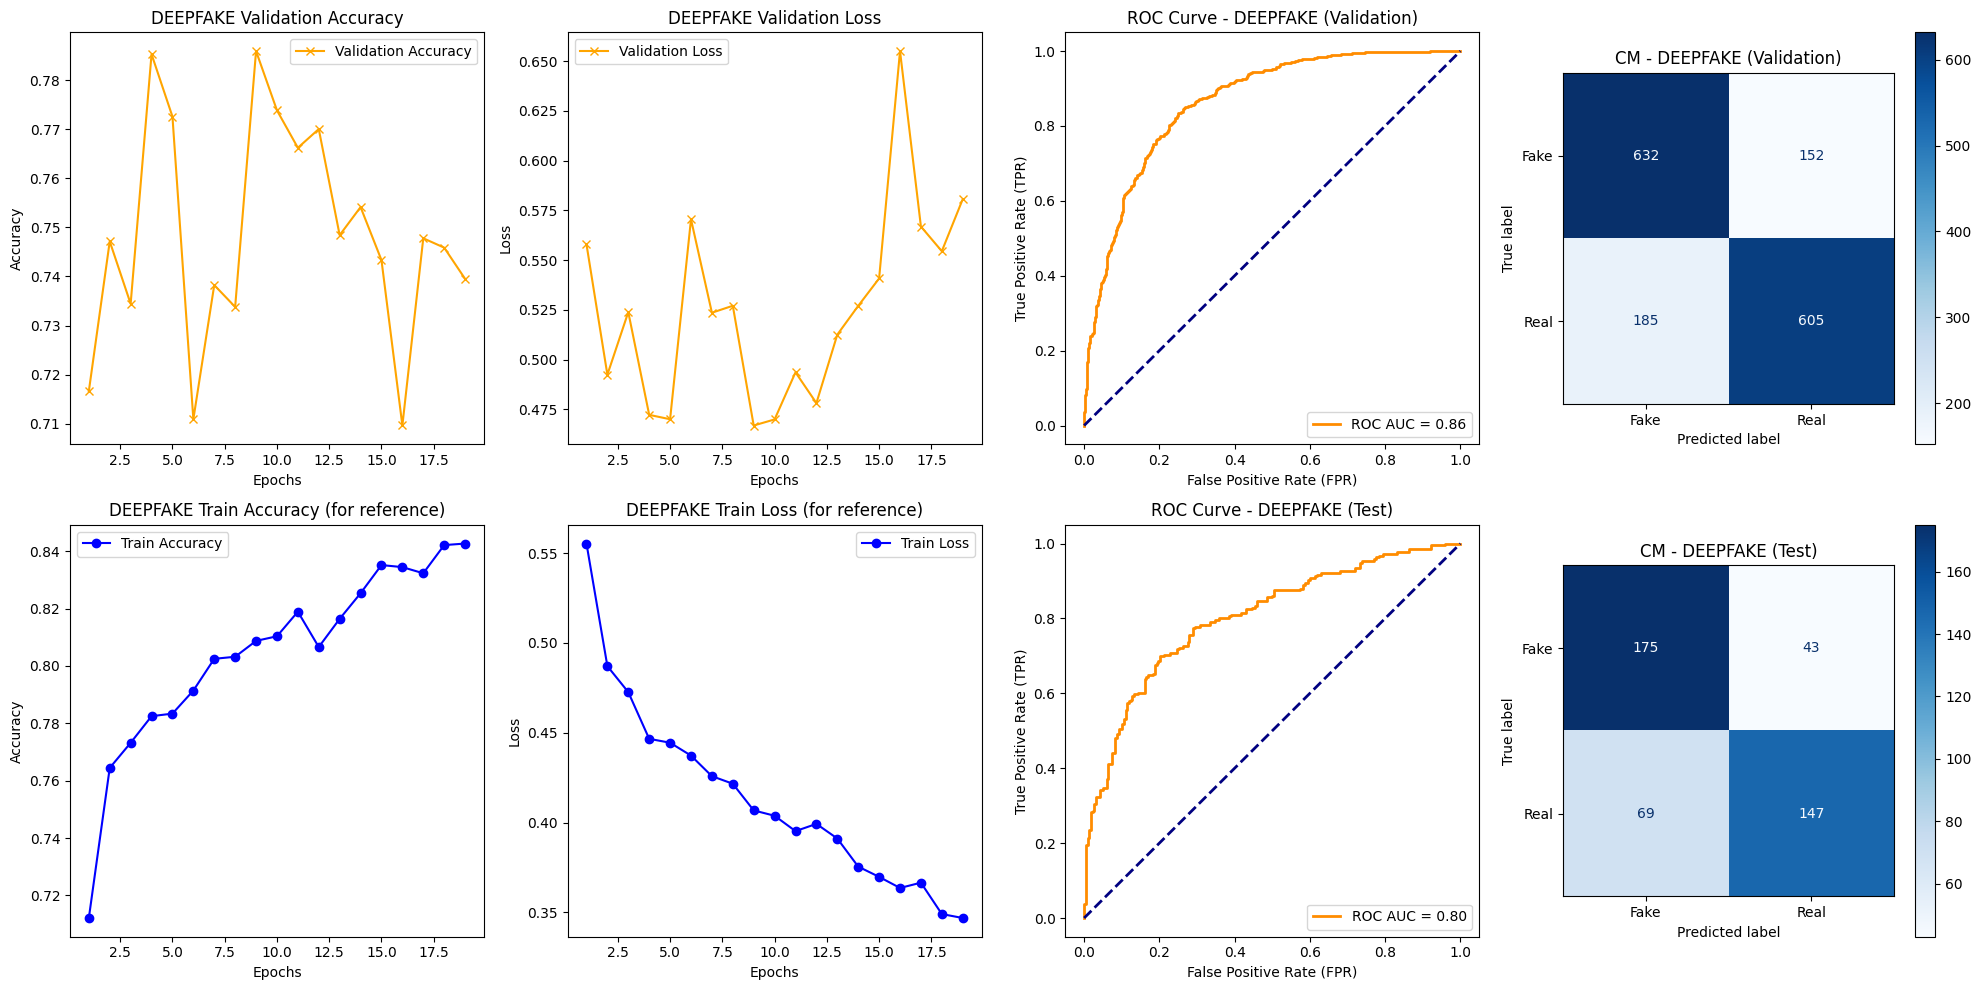


--- Training and Evaluation Complete for Deepfake Dataset ---

--- DEEPFAKE Dataset Metrics ---
              epoch      loss  accuracy        f1  precision    recall  \
0        Final Test  0.603835  0.741935  0.724138   0.773684  0.680556   
1  Final Validation  0.466836  0.785896  0.782159   0.799207  0.765823   

        auc  
0  0.802476  
1  0.864904  


In [46]:
# --- MODIFY DATASET LOOP TO RUN ONLY FOR 'deepfake' ---
dataset_names_to_run = ["deepfake"] # Changed from ["140k", "deepfake", "celebdf", "combined"] to only "deepfake"

for dataset_name in dataset_names_to_run: # Now loop only iterates once for "deepfake"
    print(f"\n{'='*50}")
    print(f"Training and Evaluating on {dataset_name.upper()} Dataset")
    print(f"{'='*50}")

    train_df = dataframes[f'{dataset_name}_train']
    valid_df = dataframes[f'{dataset_name}_valid']
    test_df = dataframes[f'{dataset_name}_test']

    # --- START OF DEBUGGING PRINTS ---
    print(f"\n--- {dataset_name.upper()} Dataset DataFrame Shapes and Heads (Before Generators) ---")
    print("Train DataFrame shape:", train_df.shape)
    print("Validation DataFrame shape:", valid_df.shape)
    print("Test DataFrame shape:", test_df.shape)
    print("\nTrain DataFrame head:")
    print(train_df.head())
    print("\nValidation DataFrame head:")
    print(valid_df.head())
    print("\nTest DataFrame head:")
    print(test_df.head())
    # --- END OF DEBUGGING PRINTS ---


    train_df['label'] = train_df['label'].astype(str)
    valid_df['label'] = valid_df['label'].astype(str)
    test_df['label'] = test_df['label'].astype(str)

    # --- START OF MARKED CHANGE ---
    if not train_df.empty and not valid_df.empty and not test_df.empty: # Check if dataframes are not empty before creating generators
        train_flow, val_flow, test_flow = create_generators(train_df, valid_df, test_df)
        metrics, history = train_and_evaluate(train_flow, val_flow, test_flow, dataset_name)

        all_metrics[dataset_name] = metrics
        all_histories[dataset_name] = history
    else:
        print(f"Warning: DataFrames for {dataset_name.upper()} dataset are empty. Skipping training and evaluation.")
    # --- END OF MARKED CHANGE ---

print("\n--- Training and Evaluation Complete for Deepfake Dataset ---") # Modified print statement

# Print metrics summary for deepfake only
if "deepfake" in all_metrics: # Check if metrics exist for deepfake
    print(f"\n--- DEEPFAKE Dataset Metrics ---") # Modified print statement
    metrics_df = pd.DataFrame(all_metrics["deepfake"]) # Access metrics for "deepfake"
    print(metrics_df)
else:
    print("\nNo metrics to print for Deepfake dataset because training was skipped (empty DataFrames).")

In [47]:
import tensorflow as tf
print(tf.__version__)

2.13.0
